In [2]:
import numpy as np
import pylab
from tqdm.notebook import tqdm
import math
import pandas as pd
from scipy.stats import chi2_contingency
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Wczytanie danych

In [3]:
data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[1826:]

# Wizualizacja danych

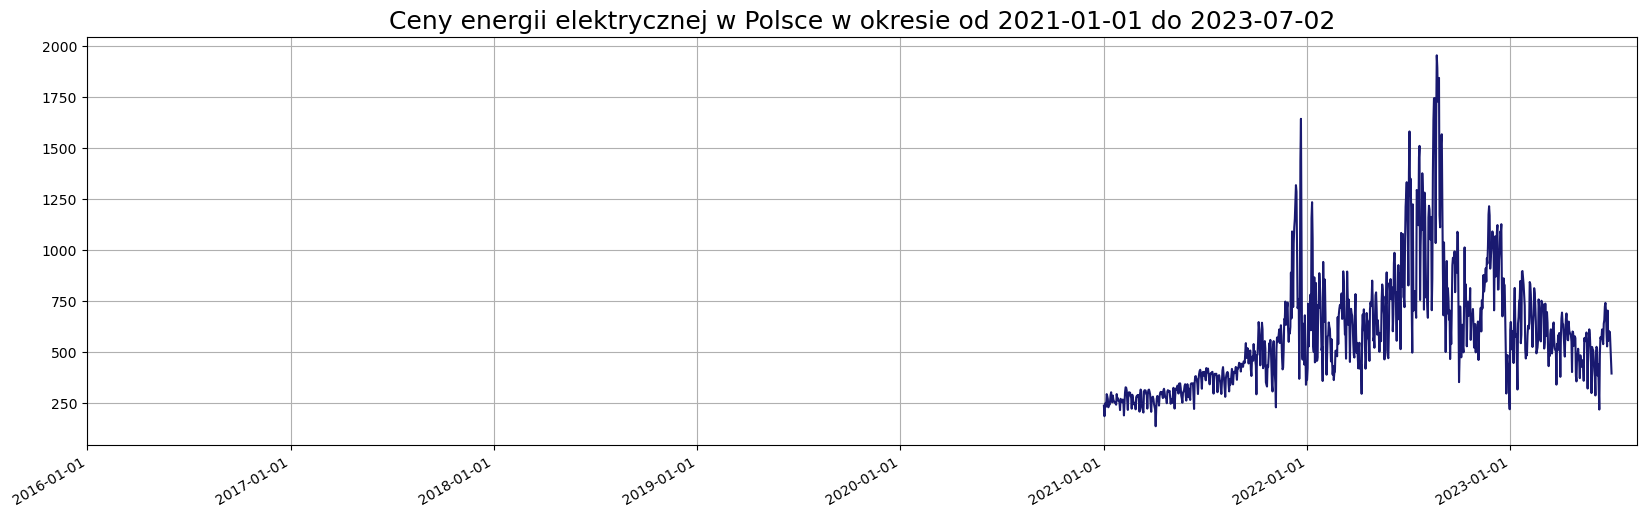

In [4]:
plt.rcParams["figure.figsize"] = (20,6)
data.plot(legend=False, color='midnightblue')
date_from = data.index[0].strftime('%Y-%m-%d')
date_to = data.index[-1].strftime('%Y-%m-%d')
plt.title(f'Ceny energii elektrycznej w Polsce w okresie od {date_from} do {date_to}', fontsize=18)
plt.xticks([datetime.strptime(f'{year}-01-01', '%Y-%m-%d') for year in [2016 + 1*i for i in range(8)]])
plt.xlabel('')
plt.grid()
plt.show()

# Estymacja parametrów $\mu, \sigma$ metodą największej wiarygodności - implementacja

In [5]:
def estimate_parameters_mle(f, g, x):
    f_min = np.inf
    a = np.linspace(0.0, 1.0, 500)[1:]
    b = np.linspace(0.0, 1.0, 500)[1:]
    x_range = np.arange(1, len(x) - 1)
    th1, th2 = np.meshgrid(a, b)
    print('a')
    f_res = f(th1.ravel(), x[x_range][:, np.newaxis])  # Add a new axis to x[x_range]
    print('b')
    g_res = g(th2.ravel(), x[x_range][:, np.newaxis])  # Add a new axis to x[x_range]
    print('c')
    mu = x[x_range] + f_res.T  # Transpose f_res
    print('d')
    sigma = g_res.T  # Transpose g_res
    print('e')
    temp = -(x[x_range + 1] - mu) ** 2 / (2.0 * sigma**2) - np.log(np.sqrt(2.0 * np.pi * sigma**2))
    print('f')
    f_log = -np.sum(temp, axis=1)
    print('g')
    min_index = np.argmin(f_log)
    print('h')
    th1min = th1.ravel()[min_index]
    th2min = th2.ravel()[min_index]
    f_min = f_log[min_index]
    print(f'Results from MLE:\nmu: {th1min}, sigma: {th2min}, f_min: {f_min}')
    return th1min, th2min

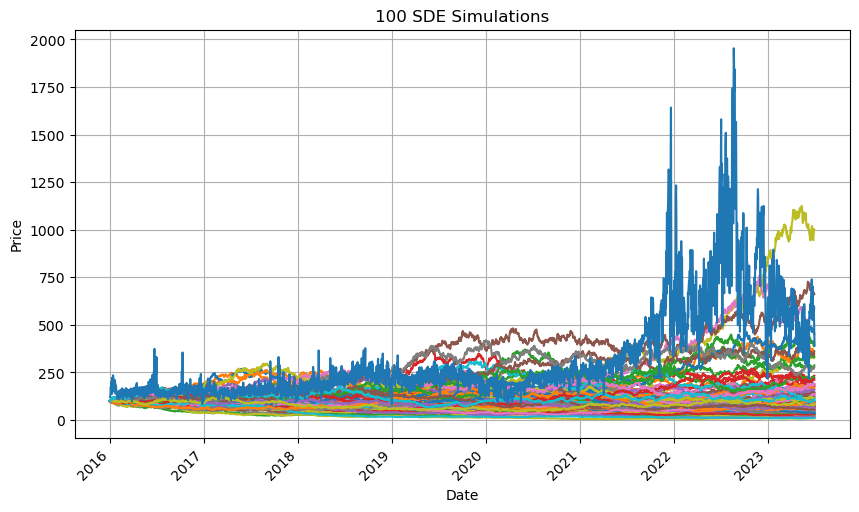

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Define the SDE coefficients
def drift(x):
    return 0.0254 * x

def diffusion(x):
    return 0.244 * x

# Define the simulation parameters
start_date = datetime(2016, 1, 2)
end_date = datetime(2023, 7, 2)
num_days = (end_date - start_date).days
num_simulations = 100  # specify the number of simulations

# Generate the dates
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Initialize the simulation variables
x0 = 100  # initial value
dt = 1/252  # time step (assuming daily data with 252 trading days per year)
x = np.zeros((num_simulations, num_days))
x[:, 0] = x0

# Simulate the SDE using Euler-Maruyama method
for i in range(num_simulations):
    for j in range(1, num_days):
        t = j * dt
        dW = np.random.normal(0, np.sqrt(dt))
        x[i, j] = x[i, j-1] + drift(x[i, j-1]) * dt + diffusion(x[i, j-1]) * dW

# Create a pandas DataFrame for the results
df = pd.DataFrame(x.T, columns=[f'Simulation {i+1}' for i in range(num_simulations)])
df['Date'] = dates

# Plot the simulated data
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(df['Date'], df[f'Simulation {i+1}'])
data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{num_simulations} SDE Simulations')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Test Goodness-of-Fit - implementacja

In [7]:
def simulate_data(SDE_model, x_prev, num_simulations):
    simulated_data = np.zeros(num_simulations)
    dt = 1  # Time step size
    f, g = SDE_model(x_prev)  # Function parameters of the SDE model
    
    for j in range(num_simulations):
        rand1 = np.random.normal(0, 1)
        x = x_prev + f * dt + math.sqrt(dt) * g * rand1
        simulated_data[j] = x
    
    return simulated_data

def goodness_of_fit_test(observed_data, SDE_model, num_simulations):
    # Generate simulated data based on the SDE model
    simulated_data = np.zeros_like(observed_data)
    with ThreadPoolExecutor() as executor:
        for i in tqdm(range(1, len(observed_data))):
            x_prev = observed_data[i-1]
            simulated_data[i] = np.mean(list(executor.submit(simulate_data, SDE_model, x_prev, num_simulations).result()))
    
    # Calculate observed and expected frequencies
    observed_freq = np.histogram(observed_data, bins=20)[0]
    expected_freq = np.histogram(simulated_data, bins=20)[0]
    
    # Pad the smaller array with zeros to make both arrays have the same size
    max_size = max(len(observed_freq), len(expected_freq))
    observed_freq = np.pad(observed_freq, (0, max_size - len(observed_freq)))
    expected_freq = np.pad(expected_freq, (0, max_size - len(expected_freq)))
    
    # Perform chi-squared test
    contingency_table = np.vstack((observed_freq, expected_freq))
    chi2_stat, p_value = chi2_contingency(contingency_table)[:2]  # Take only the first two elements of the returned tuple
    
    # Determine if the model has goodness-of-fit or lack-of-fit
    threshold = 0.005  # Significance level
    print('Results from Goodness-of-Fit test:')
    if p_value < threshold:
        result = "Lack-of-fit"
    else:
        result = "Goodness-of-fit"
    
    return chi2_stat, p_value, result

# Wykorzystanie testu do wybranych modeli

In [6]:
x = data.values

## Model Blacka-Scholesa

Równanie Blacka-Scholesa:

$dX(t) = \mu X(t) dt + \sigma X(t) d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera

In [10]:
f = lambda mu, x: mu * x
g = lambda sigma, x: sigma * x
mu, sigma = estimate_parameters_mle(f, g, x)

a
b
c
d
e
f
g
h
Results from MLE:
mu: 0.026052104208416832, sigma: 0.2444889779559118, f_min: 5701.925170989994


In [11]:
def SDE_model(x):
    mu = 0.026
    sigma = 0.244
    f = mu * x
    g = sigma * x
    return f, g

num_simulations = 1000

chi2_stat, p_value, result = goodness_of_fit_test(x, SDE_model, num_simulations)

print(f'Chi-square statistic: {chi2_stat}')
print("P-value:", p_value)
print("Result:", result)

  0%|          | 0/909 [00:00<?, ?it/s]

Results from Goodness-of-Fit test:
Chi-square statistic: 179.87150080012805
P-value: 3.2793471771519333e-28
Result: Lack-of-fit


## Model Ornsteina-Uhlenbecka

Model jest postaci:
    
$dX(t) = -\mu X(t) dt + \sigma d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera

In [ ]:
f = lambda mu, x: -mu * x
g = lambda sigma, x: sigma
mu, sigma = estimate_parameters_mle(f, g, x)

In [105]:
def SDE_model(x):
    mu = 0.0094
    sigma = 1
    f = -mu * x
    g = sigma
    return f, g

num_simulations = 1000

chi2_stat, p_value, result = goodness_of_fit_test(x, SDE_model, num_simulations)

print(f'Chi-square statistic: {chi2_stat}')
print("P-value:", p_value)
print("Result:", result)

  0%|          | 0/2735 [00:00<?, ?it/s]

Results from Goodness-of-Fit test:
Chi-square statistic: 1040.8447540768948
P-value: 1.0068943095450066e-208
Result: Lack-of-fit


## Model CIR

Model jest postaci:
    
$dX(t) = a(b-X(t)) dt + \sigma \sqrt{X(t)}d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera